### Construct low and high resolution numpy array of raw MRI 3D data(without RSS) from kspace data

In [1]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import helpers as H
from fastMRI.data import transforms as T
from fastMRI.common.subsample import MaskFunc
from tqdm import tqdm

#Root directory of the project
ROOT_DIR = os.path.abspath(".")
TRAIN_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")
train_h5_files = glob.glob(os.path.join(TRAIN_DATASET_PATH,'singlecoil_train','*.h5'))
print(len(train_h5_files))

8


In [2]:
def sub_sample_kspace(vol, mask_func):
    """
    Transform a kpsace tensor to an undersampled 3D image using mask object 4x or 8x.
    Args:
        vol: kspace tensor
        mask_func: mask function object (4x, 8x)
    Returns:
        sampled_image: output undersampled 3D image volume
    """
    
    # 1. convert numpy to torch tensor
    kspace2ttensor = T.to_tensor(vol)
    
    # 2. apply mask to kspace
    masked_kspace, mask = T.apply_mask(kspace2ttensor, mask_func)   
    
    # 3. inverse fast fourier transform 2D
    sampled_image = T.ifft2(masked_kspace)
    
    # 4. compute absolute value to get a real image
    sampled_image_abs = T.complex_abs(sampled_image)
    
    # 5. centre crop to 320x320
    cropped_image = T.center_crop(sampled_image_abs, (320, 320))
    
    # 6. Normalize
    #cropped_image_norm, _, _ = T.normalize_instance(cropped_image, eps=1e-11)

    # 7. convert torch tensor to good old numpy array
    sampled_image = np.abs(cropped_image.numpy())
    
    return sampled_image


def recon_ground_truth(vol):
    '''
    Reconstructs ground truth image from gt tensor of shape (slices, w, h).    
    Args: 
        vol: hdf5 dataset of voulume (slices,w,h) from ESC or RSS
    Returns: 
        recon_img: 3D volume of shape (slice, w, h)
    '''
    
    # Convert to np from hdf5 dataset
    vol_gt = np.array(vol)
    
    ### FOR NORMALIZATION
    
    # Convert to torch tensor
    #gt_tensor = T.to_tensor(vol_gt)
    # Normalize
    #gt_img, _, _ = T.normalize_instance(gt_tensor, eps=1e-11)
    # Convert torch tensor to numpy
    #vol_gt = np.abs(gt_img.numpy())
    
    return vol_gt


def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

### Get a single MRI file

In [3]:
train_h5_files[0]

'/home/hasib/MRI-reconstruction/dataset/singlecoil_train/file1000002.h5'

In [4]:
file = train_h5_files[2]
hf = h5py.File(file)
print(type(hf))

<class 'h5py._hl.files.File'>


In [5]:
# Create a mask function object for undersampling

mask_func = MaskFunc(center_fractions=[0.04, 0.08], accelerations=[8, 4])
mask_func_4x = MaskFunc(center_fractions=[0.08], accelerations=[4])
mask_func_8x = MaskFunc(center_fractions=[0.04], accelerations=[8])  

### 1. Kspace tensor

In [6]:
kspace_tensor = hf['kspace'][()]
print(kspace_tensor.shape)
img_3d = sub_sample_kspace(kspace_tensor, mask_func)
print(img_3d.shape)

(34, 640, 368)
(34, 320, 320)


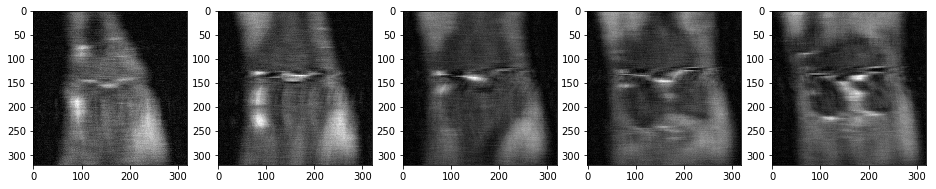

In [7]:
slice_num = [12, 16, 19, 22, 24]
show_slices(img_3d, slice_num, cmap='gray')

2.563601e-09 0.00010712974


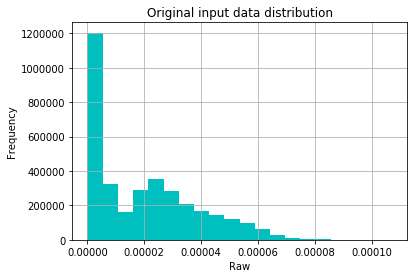

In [8]:
img_flat = img_3d.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Original input data distribution")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [9]:
#img_norm = H.normalize(img_3d)
#img_norm.shape

In [10]:
#img_flat = img_norm.flatten()
#print(min(img_flat), max(img_flat))
#plt.hist(img_flat, bins=20, color='c')
#plt.title("After normalization")
#plt.xlabel("Raw")
#plt.grid(True)
#plt.ylabel("Frequency")
#plt.show()

In [11]:
#y = img_norm
#y = y.flatten()
#max(y), min(y)

### After normalization

In [12]:
#slice_num = [12, 16, 19, 22, 24]
#show_slices(img_norm, slice_num, cmap='gray')

### 2. Ground truth 

(34, 320, 320)
(34, 320, 320)


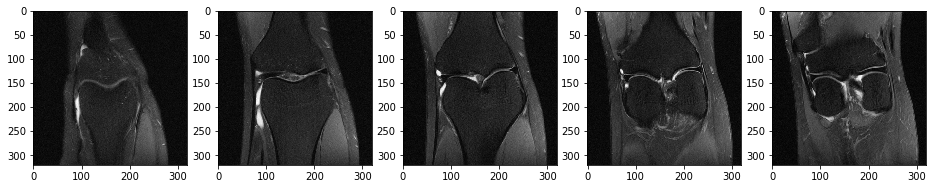

In [13]:
gt_rss = hf['reconstruction_rss']
print(gt_rss.shape)
img_3d_gt = recon_ground_truth(gt_rss)
print(img_3d_gt .shape)

show_slices(img_3d_gt, slice_num, cmap='gray')

4.5213555e-06 0.00018414124


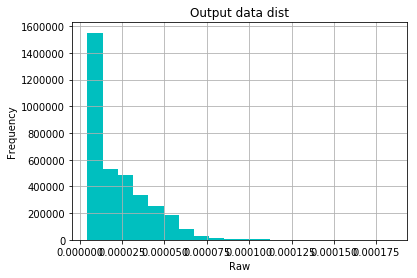

In [14]:
img_flat = img_3d_gt.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Output data dist")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [15]:
#y = img_3d_gt[12] 
#y = y.flatten()
#max(y), min(y)

### Construct dataset for low and high resolution MRI scans

In [16]:
# Create a mask function object for undersampling

# randomly sample 4x and 8x accelerations
mask_func = MaskFunc(center_fractions=[0.04, 0.08], accelerations=[8, 4])

# 4x
mask_func_4x = MaskFunc(center_fractions=[0.08], accelerations=[4])

# 8x
mask_func_8x = MaskFunc(center_fractions=[0.04], accelerations=[8])  

In [17]:
# Make folder for low and high res

LOW_DIR = "singlecoil_train_3D_images_48x/low/"
HIGH_DIR = "singlecoil_train_3D_images_48x/high/"

H.create_directory("{}/{}".format(TRAIN_DATASET_PATH, LOW_DIR))
H.create_directory("{}/{}".format(TRAIN_DATASET_PATH, HIGH_DIR))

In [18]:
LOW_DIR_PATH = os.path.join(TRAIN_DATASET_PATH, LOW_DIR)
HIGH_DIR_PATH = os.path.join(TRAIN_DATASET_PATH, HIGH_DIR)
LOW_DIR_PATH, HIGH_DIR_PATH

('/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/low/',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high/')

In [19]:
len(train_h5_files)

8

In [20]:
i=0
for file in train_h5_files:
    i+=1
    
    hf = h5py.File(file)
    
    # transform and save low res image
    kspace_tensor = hf['kspace'][()]
    img_3d = sub_sample_kspace(kspace_tensor, mask_func) # 4x, 8x acceleration (NOW 4x8x acceleration)
    
    #img_3d = H.normalize(img_3d)
    
    # Save X 
    np.save("{}/{}.npy".format(LOW_DIR_PATH, i), img_3d)

    
    # transform and save ground truth(RSS)
    gt_rss = hf['reconstruction_rss']
    img_3d_gt = recon_ground_truth(gt_rss)
    
    #img_3d_gt = H.normalize(img_3d_gt)
    
    # Save Y
    np.save("{}/{}.npy".format(HIGH_DIR_PATH, i), img_3d_gt)
    
    # Show progress
    print(i, file[-15:], "raw data - ", kspace_tensor.shape, "--", "input volume - ", img_3d.shape, "--", "output volume - ", img_3d_gt.shape)

    

1 /file1000002.h5 raw data -  (38, 640, 368) -- input volume -  (38, 320, 320) -- output volume -  (38, 320, 320)
2 /file1000027.h5 raw data -  (34, 640, 368) -- input volume -  (34, 320, 320) -- output volume -  (34, 320, 320)
3 /file1000023.h5 raw data -  (34, 640, 368) -- input volume -  (34, 320, 320) -- output volume -  (34, 320, 320)
4 /file1000003.h5 raw data -  (45, 640, 368) -- input volume -  (45, 320, 320) -- output volume -  (45, 320, 320)
5 /file1000001.h5 raw data -  (36, 640, 372) -- input volume -  (36, 320, 320) -- output volume -  (36, 320, 320)
6 /file1000010.h5 raw data -  (36, 640, 368) -- input volume -  (36, 320, 320) -- output volume -  (36, 320, 320)
7 /file1000021.h5 raw data -  (35, 640, 368) -- input volume -  (35, 320, 320) -- output volume -  (35, 320, 320)
8 /file1000005.h5 raw data -  (35, 640, 372) -- input volume -  (35, 320, 320) -- output volume -  (35, 320, 320)


### Sanity check

In [21]:
len(os.listdir(LOW_DIR_PATH)), len(os.listdir(HIGH_DIR_PATH))

(8, 8)

In [22]:
# remember to read data in same sequence to retain x,y mapping for each MRI scan
os.listdir(LOW_DIR_PATH)[:3], os.listdir(HIGH_DIR_PATH)[:3]

(['4.npy', '2.npy', '3.npy'], ['4.npy', '2.npy', '3.npy'])

In [23]:
print("Done!")

Done!
